# Time-series Anomaly Detection
This demo shows how to use a novel SLS (Streaming Least Squares) anomaly detection algorithm and how it performs


In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


First, let's take a quick look at our sample time-series data file, which consists of 2 columns: datetime and counter value, aggregated every 15 minutes.

In [2]:
df = pd.read_csv('data/sample.csv', parse_dates=True, index_col=0)
data = df['Counter']
df.head(10)

,Counter
Date,
2014-08-31 15:15:00,800
2014-08-31 15:30:00,685
2014-08-31 15:45:00,642
2014-08-31 16:00:00,637
2014-08-31 16:15:00,648
2014-08-31 16:30:00,802
2014-08-31 16:45:00,804
2014-08-31 17:00:00,814
2014-08-31 17:15:00,646


Now, simply import the Time Series module and run the DetectAnomalies function.

In [3]:
import AnomalyDetection as sls

Time Interval                                Anomaly Score
2014-09-08 22:15:00 - 2014-09-09 03:00:00    2197.57
2014-09-09 17:45:00 - 2014-09-09 22:30:00    1910.83
--------------- Threshold level 2: 1691.08 ---------------
2014-10-20 16:00:00 - 2014-10-20 20:45:00    1471.33
--------------- Threshold level 1: 1196.08 ---------------


Thresholds: [1691.0794831277858, 1196.0847066751198]


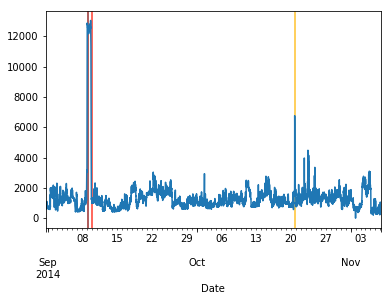

In [4]:
anomalies, thresholds = sls.DetectAnomalies(data, 20, levels=2, visualize=True)
print("\n\nThresholds:", thresholds)

##### Refactored visualisation

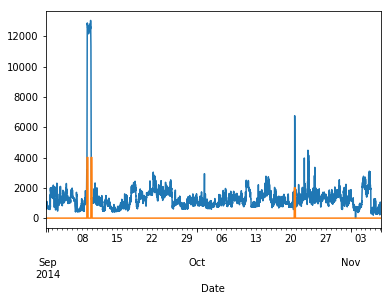

In [5]:
detected = sls.AnomaliesToSeries(anomalies, data.index)
data.plot()
(detected * 2000).plot()
plt.show()

Try again with just 1 level of anomaly

Time Interval                                Anomaly Score
2014-09-08 22:15:00 - 2014-09-09 03:00:00    2197.57
2014-09-09 17:45:00 - 2014-09-09 22:30:00    1910.83
2014-10-20 16:00:00 - 2014-10-20 20:45:00    1471.33
--------------- Threshold level 1: 1196.08 ---------------


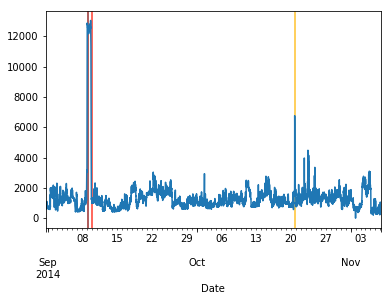

In [6]:
anomalies, thresholds = sls.DetectAnomalies(data, 20, levels=1, visualize=True);

##### Refactored visualisation

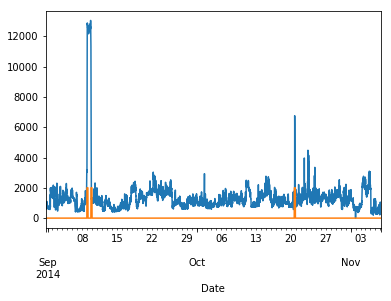

In [7]:
detected = sls.AnomaliesToSeries(anomalies, data.index)
data.plot()
(detected * 2000).plot()
plt.show()

For this problem, we're interested in detecting anomalous spikes in the data. The same algorithm can be used for detecting dips as well, e.g. outages (sudden drop in sessions serverd).

_____

## Model deployment for real-time anomaly detection

The demo here is for evaluting the effectiveness of the algorithm on historical data. To deploy the model for **real-time** detection on streaming data, follow this C++ API.

<pre>    <span style=' color: Blue;'>typedef</span> <span style=' color: Blue;'>std</span>::vector&lt;<span style=' color: Blue;'>float</span>&gt; FloatVec; 

    <span style=' color: Blue;'>class</span> AnomalyDetector { 
    <span style=' color: Blue;'>public</span>: 
        <span style=' color: Green;'>/// Alert Thresholds, which can be updated (if needed) live without breaking the service</span>
        FloatVec Thresholds; 

        <span style=' color: Green;'>/// Instantiate the detector from window size and Thresholds</span>
        AnomalyDetector(<span style=' color: Blue;'>int</span> windowSize, FloatVec&gt;&amp; thresholds); 

        <span style=' color: Green;'>/// Instantiate the detector from a saved model file</span> 
        AnomalyDetector(<span style=' color: Blue;'>const</span> <span style=' color: Blue;'>char</span>* modelFile);
         
        <span style=' color: Green;'>/// Save the detector to a model file</span> 
        <span style=' color: Blue;'>void</span> Save(<span style=' color: Blue;'>const</span> <span style=' color: Blue;'>char</span>* modelFile);
         
        <span style=' color: Green;'>/// Predict takes an incoming counter value and returns the alert level (0 means no anomaly).</span> 
        <span style=' color: Green;'>/// It also produces auxiliary outputs such as trend and the anomaly score </span>
        <span style=' color: Blue;'>int</span> Predict(<span style=' color: Blue;'>float</span> value, <span style=' color: Blue;'>float</span>&amp; trend, <span style=' color: Blue;'>float</span>&amp; score);
    };</pre>

1. Instantiate the anomaly detector from the model file.
2. Then, for each new counter value, call *Predict* to get the alert level as well as the trend and anomaly score.

### Bulk Predict
We also provide a bulk predict API for handling multiple signals in parallel (via *OpenMP*).
<pre>    <span style=' color: Blue;'>class</span> BulkAnomalyDetector { 
9se    <span style=' color: Blue;'>public</span>: 
        <span style=' color: Blue;'>std</span>::vector&lt;FloatVec&gt; Thresholds; 

        <span style=' color: Green;'>/// Instantiate the detectors from a zipped container of model files</span>
        BulkAnomalyDetector(<span style=' color: Blue;'>const</span> <span style=' color: Blue;'>char</span>* modelsContainerFile);

        <span style=' color: Blue;'>std</span>::vector&lt;<span style=' color: Blue;'>int</span>&gt; BulkPredict(<span style=' color: Blue;'>const</span> FloatVec&amp; value, FloatVec&amp; trends, FloatVec&amp; scores);
    }; 
</pre>

### Python Interface
We also provide Python bindings if the rest of your services is in Python.